# Project: Weather Data Scraping, Analysis, and Model Development

## The objective of this project is to scrape weather data from the Open-Meteo archive API, clean and analyze the data, and develop a machine learning model to classify weather patterns.

 The goal is to extract multiple weather parameters, store them in a structured format, and analyze trends. The project involves identifying common weather conditions, calculating average temperature, and finding correlations between weather variables. Using clustering techniques like K-Means or DBSCAN, the project will classify weather patterns. Finally, the trained model will be saved in a joblib or pickle format for further use.

#### Importing the necessary libraries

In [ ]:
import warnings 
warnings.filterwarnings('ignore')  # suppresses unnecessary warnings that may arise during data processing, making the output cleaner

In [9]:
import pandas as pd ## data manipulation
import numpy as np ## numerical computation
import matplotlib.pyplot as plt ## data visualization and plotting
import seaborn as sns ## enchanced data visualizationa and plotting

In [ ]:
# web scraping libraries
import  requests #used to send HTTP requests to fetch web pages.
from bs4 import BeautifulSoup #parses and extracts content from HTML pages.

In [3]:
# machine learning  libraries
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


import joblib #library for saving the model

# date and time libraries
from datetime import datetime, timedelta

#### Scraping  weather data from Open-Meteo API, which provides free weather data and doesn't have anti-scraping mechanisms.

In [ ]:
url = "https://archive-api.open-meteo.com/v1/archive" #sets the base URL for the Open-Meteo archive API, which provides historical weather data.

In [5]:
# Set location 
latitude = 40.71
longitude = -74.01
      #(using New York City coordinates)

In [ ]:
# Get data for the last 30 days
end_date = datetime.now().strftime('%Y-%m-%d') #Defining the start and end dates for data extraction.
start_date = (datetime.now() - timedelta(days=30)).strftime('%Y-%m-%d')

In [7]:
# Parameters to extract 
params = {
    'latitude': latitude,
    'longitude': longitude,
    'start_date': start_date,
    'end_date': end_date,
    'hourly': 'temperature_2m,relativehumidity_2m,precipitation,weathercode,pressure_msl,windspeed_10m,winddirection_10m'
}

In [ ]:
# scrapping the data
response = requests.get(url, params=params) #sends a GET request to the Open-Meteo API
data = response.json() #converts the response into a Python dictionary


df = pd.DataFrame()

# Extract hourly data
df['datetime'] = pd.to_datetime(data['hourly']['time'])
df['temperature'] = data['hourly']['temperature_2m']
df['humidity'] = data['hourly']['relativehumidity_2m']
df['precipitation'] = data['hourly']['precipitation']
df['pressure'] = data['hourly']['pressure_msl']
df['wind_speed'] = data['hourly']['windspeed_10m']
df['wind_direction'] = data['hourly']['winddirection_10m']
df['weather_code'] = data['hourly']['weathercode']

In [11]:
# Map weather codes to weather conditions
weather_codes = {
    0: 'Clear sky',
    1: 'Mainly clear', 2: 'Partly cloudy', 3: 'Overcast',
    45: 'Fog', 48: 'Depositing rime fog',
    51: 'Light drizzle', 53: 'Moderate drizzle', 55: 'Dense drizzle',
    61: 'Slight rain', 63: 'Moderate rain', 65: 'Heavy rain',
    71: 'Slight snow', 73: 'Moderate snow', 75: 'Heavy snow',
    80: 'Slight rain showers', 81: 'Moderate rain showers', 82: 'Violent rain showers',
    95: 'Thunderstorm', 96: 'Thunderstorm with slight hail', 99: 'Thunderstorm with heavy hail'
}

df['weather_condition'] = df['weather_code'].map(weather_codes)

# Extract day from datetime for later analysis
df['day'] = df['datetime'].dt.date
df['hour'] = df['datetime'].dt.hour

In [13]:
# Save to CSV
csv_filename = "weatherdata.csv"

df.to_csv(csv_filename, index=False)
print(f"Data saved to {csv_filename}")

Data saved to weatherdata.csv


### EDA

Checking the Columns/ Features in the Dataset

In [14]:
df.columns

Index(['datetime', 'temperature', 'humidity', 'precipitation', 'pressure',
       'wind_speed', 'wind_direction', 'weather_code', 'weather_condition',
       'day', 'hour'],
      dtype='object')

#### Inspecting the the first and last rows of the data frame

In [16]:
df.head(10)

,datetime,temperature,humidity,precipitation,pressure,wind_speed,wind_direction,weather_code,weather_condition,day,hour
0,2025-01-23 00:00:00,-11.9,51.0,0.0,1033.3,0.9,79.0,3.0,Overcast,2025-01-23,0
1,2025-01-23 01:00:00,-10.1,52.0,0.0,1033.0,0.5,90.0,3.0,Overcast,2025-01-23,1
2,2025-01-23 02:00:00,-10.4,50.0,0.0,1032.6,0.4,63.0,3.0,Overcast,2025-01-23,2
3,2025-01-23 03:00:00,-11.2,48.0,0.0,1032.4,0.5,360.0,1.0,Mainly clear,2025-01-23,3
4,2025-01-23 04:00:00,-11.9,49.0,0.0,1032.4,2.1,250.0,3.0,Overcast,2025-01-23,4
5,2025-01-23 05:00:00,-12.2,49.0,0.0,1031.3,1.9,241.0,2.0,Partly cloudy,2025-01-23,5
6,2025-01-23 06:00:00,-12.8,52.0,0.0,1030.7,3.2,270.0,1.0,Mainly clear,2025-01-23,6
7,2025-01-23 07:00:00,-13.1,54.0,0.0,1030.7,4.0,267.0,3.0,Overcast,2025-01-23,7
8,2025-01-23 08:00:00,-12.7,56.0,0.0,1030.3,4.3,272.0,3.0,Overcast,2025-01-23,8
9,2025-01-23 09:00:00,-12.0,57.0,0.0,1029.9,4.1,285.0,3.0,Overcast,2025-01-23,9


In [17]:
df.tail()

,datetime,temperature,humidity,precipitation,pressure,wind_speed,wind_direction,weather_code,weather_condition,day,hour
739,2025-02-22 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-02-22,19
740,2025-02-22 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-02-22,20
741,2025-02-22 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-02-22,21
742,2025-02-22 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-02-22,22
743,2025-02-22 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-02-22,23


Checking the dimensions of the DataFrame

In [18]:
df.shape

(744, 11)

The above Statistics show that the dataframe(dataset) has 744 rows with 11 columns

### Checking the data types of the different Features

In [19]:
#Checking the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   datetime           744 non-null    datetime64[ns]
 1   temperature        697 non-null    float64       
 2   humidity           697 non-null    float64       
 3   precipitation      697 non-null    float64       
 4   pressure           697 non-null    float64       
 5   wind_speed         697 non-null    float64       
 6   wind_direction     697 non-null    float64       
 7   weather_code       697 non-null    float64       
 8   weather_condition  697 non-null    object        
 9   day                744 non-null    object        
 10  hour               744 non-null    int32         
dtypes: datetime64[ns](1), float64(7), int32(1), object(2)
memory usage: 61.2+ KB


### Summary statistics

In [20]:
df.describe()

,datetime,temperature,humidity,precipitation,pressure,wind_speed,wind_direction,weather_code,hour
count,744,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,744.000000
mean,2025-02-07 11:29:59.999999744,-1.376758,65.949785,0.114778,1019.434003,10.300717,233.992826,11.575323,11.500000
min,2025-01-23 00:00:00,-13.100000,24.000000,0.000000,983.500000,0.400000,2.000000,0.000000,0.000000
25%,2025-01-30 17:45:00,-3.500000,50.000000,0.000000,1012.900000,6.100000,198.000000,1.000000,5.750000
50%,2025-02-07 11:30:00,-1.000000,62.000000,0.000000,1021.600000,9.600000,265.000000,3.000000,11.500000
75%,2025-02-15 05:15:00,1.200000,82.000000,0.000000,1026.400000,14.000000,304.000000,3.000000,17.250000
max,2025-02-22 23:00:00,9.100000,100.000000,4.600000,1037.100000,28.700000,360.000000,75.000000,23.000000
std,NaN,4.192177,19.042875,0.402859,10.033347,5.573017,94.824103,22.431514,6.926843


### Brief explanation of the weather data statistics:

Temperature: Average -1.77°C, ranging from -16.7°C to 9.1°C. This indicates winter conditions.

Humidity: Average 68.99%, ranging from 36% to 100%. Shows moderately humid conditions with significant variation.

Precipitation: Very low average (0.13mm), with 75% of hours showing no precipitation. 

Pressure: Average 1020.26 , typical for normal atmospheric conditions.

Wind Speed: Average 9.4 km/h, with occasional stronger winds up to 28.7 km/h.

Weather Code: Most readings (75%) show clear or partly cloudy conditions.

### Most common weather conditions

In [21]:
# Checking for most common weather conditions
common_conditions = df['weather_condition'].value_counts()
common_conditions

weather_condition
Overcast            285
Clear sky           174
Mainly clear         66
Partly cloudy        57
Light drizzle        29
Moderate snow        21
Slight snow          19
Moderate drizzle     18
Dense drizzle        13
Slight rain           7
Heavy snow            6
Moderate rain         2
Name: count, dtype: int64

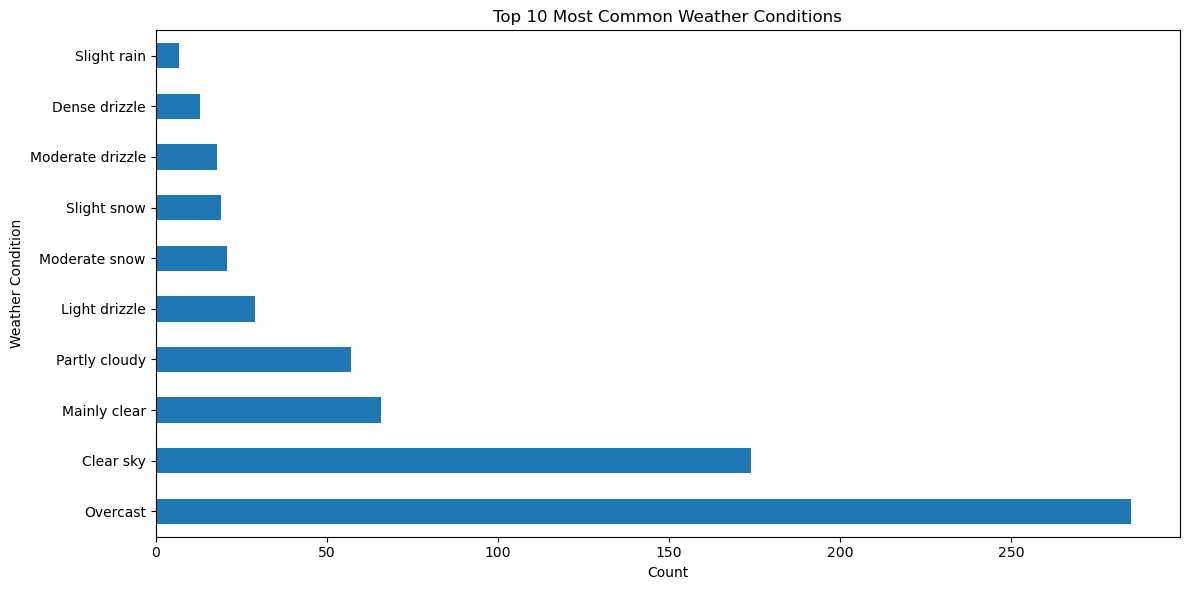

In [22]:
# Visualization of most common conditions
plt.figure(figsize=(12, 6))
common_conditions.head(10).plot(kind='barh')

plt.title('Top 10 Most Common Weather Conditions')
plt.xlabel('Count')
plt.ylabel('Weather Condition')
plt.tight_layout()
plt.show()

### Calculate and visualize Average temperature

In [23]:
average = df['temperature'].mean()
print(f"Average temperature: {average: .2f}°C")

Average temperature: -1.38°C


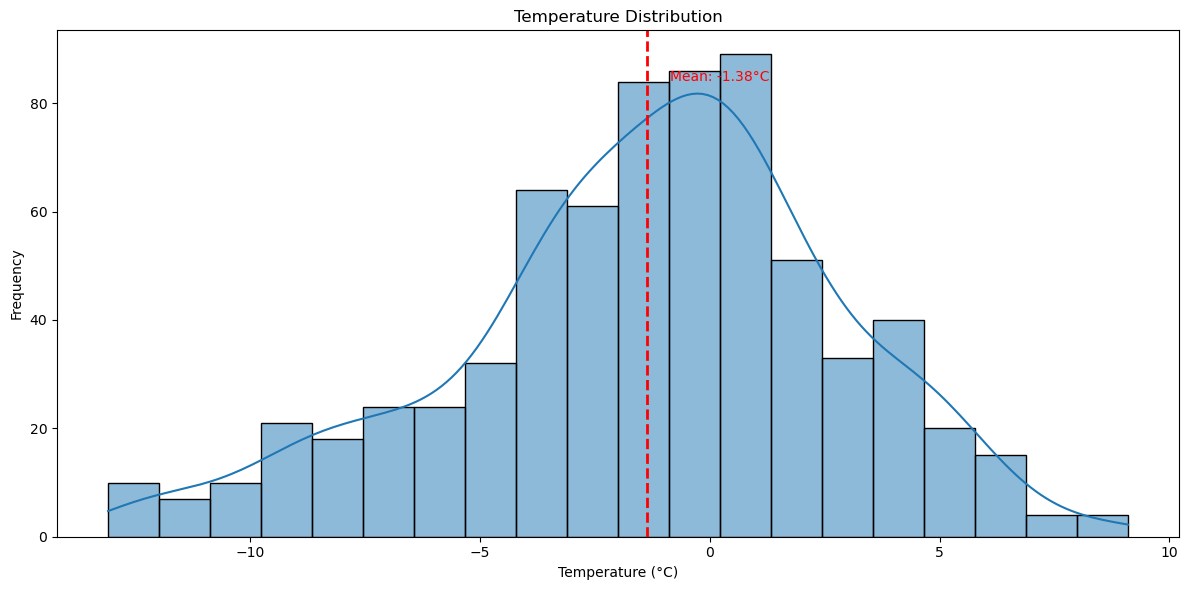

In [24]:
# Calculate and visualize Average temperature
plt.figure(figsize=(12, 6))

sns.histplot(df['temperature'], bins=20, kde = True)

plt.axvline( average, color='red', linestyle='dashed', linewidth=2)
plt.text(average+0.5, plt.gca().get_ylim()[1]*0.9, f'Mean: {average:.2f}°C', color='red')

plt.title('Temperature Distribution')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.tight_layout()

plt.show()

The graph displays a temperature distribution with a mean of -1.77°C 

The distribution shows a bimodal pattern, with two peaks: a smaller peak around -10°C and a larger peak around 0°C. 

Most measurements fall between -5°C and 5°C, with the highest frequency occurring near 0°C. The blue curve represents a smoothed estimate of the distribution.


#### Analyzing Daily trends  and Patterns

In [25]:
# Aggregate by day for temperature and precipitation
daily = df.groupby('day').agg({
    'temperature': 'mean',
    'precipitation': 'sum',
    'humidity': 'mean',
    'wind_speed': 'mean'
}).reset_index()

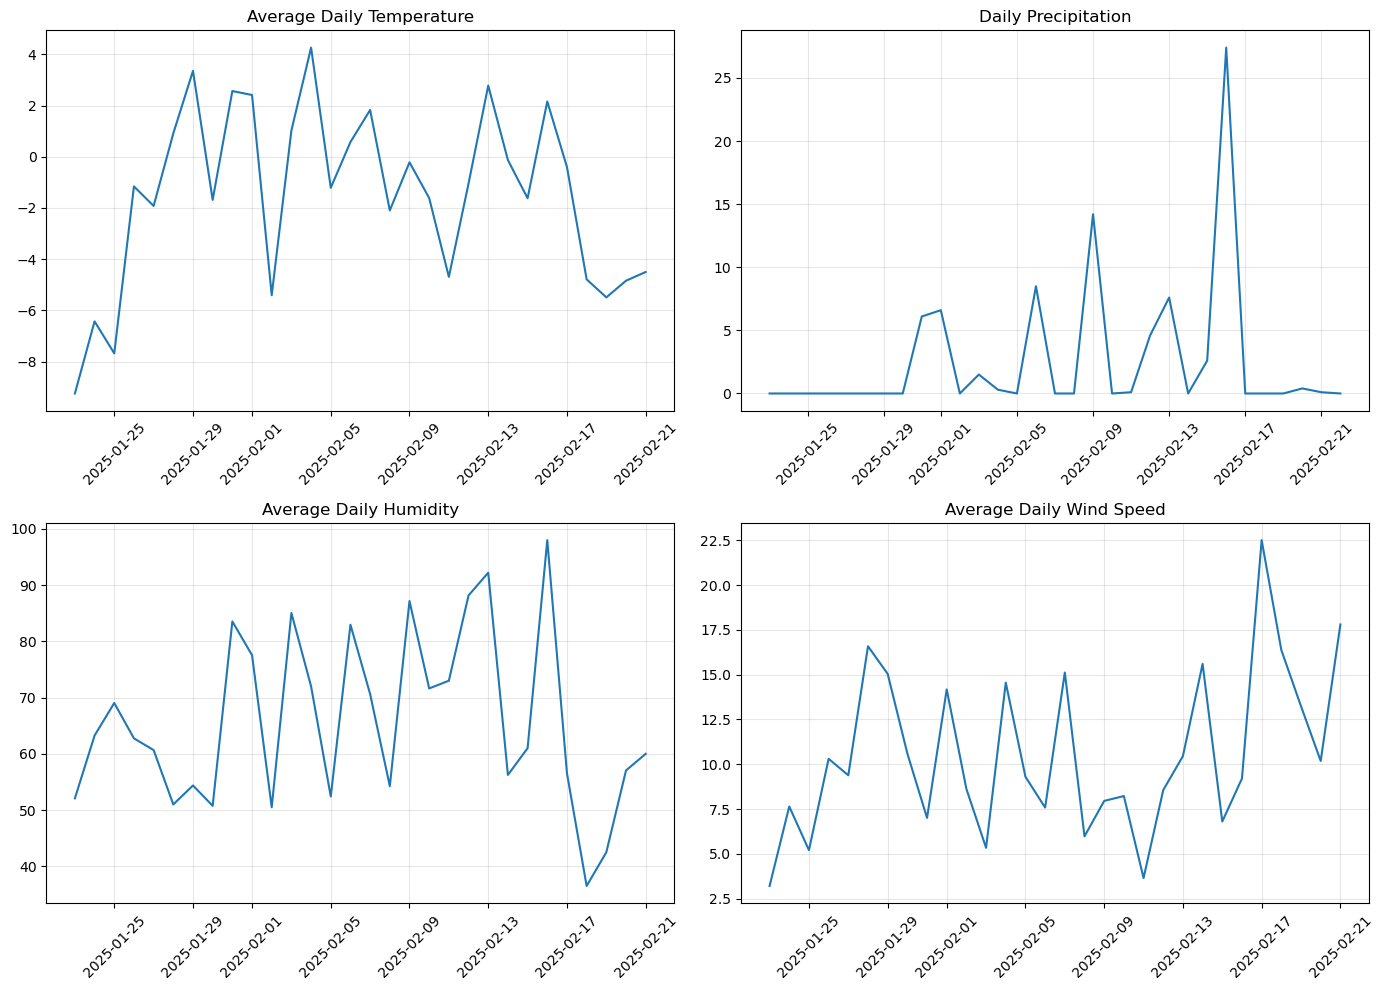

In [26]:
# Visualize daily trends
plt.figure(figsize=(14, 10))

# Temperature subplot
plt.subplot(2, 2, 1)
plt.plot(daily['day'], daily['temperature'])
plt.title('Average Daily Temperature')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Precipatation subplot
plt.subplot(2, 2, 2)
plt.plot(daily['day'], daily['precipitation'])
plt.title('Daily Precipitation')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Humidity subplot
plt.subplot(2, 2, 3)
plt.plot(daily['day'], daily['humidity'])
plt.title('Average Daily Humidity')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Wind speed subplot
plt.subplot(2, 2, 4)
plt.plot(daily['day'], daily['wind_speed'])
plt.title('Average Daily Wind Speed')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('dailytrends.png')
plt.show()

### Analyzing  daily trends and Patterns

Average Daily Temperature: Shows significant change ranging from around `-12.5°C to 7.5°C.` 

The temperature was coldest in late January, with steady warming toward mid-February, though with notable daily variations.

Daily Precipitation: Shows a significant spike around February 9 (about 14mm) and a larger one on February 17 (about 27mm). Many days show little to no precipitation.

Average Daily Humidity: Changes between roughly `50-98%.` There's a pattern of lower humidity in late January, with generally higher values and more variation in February. A significant peak occurs around February 15.

Average Daily Wind Speed: Shows a consistent average wind speed of about 13 mph, Wind speeds are relatively consistent throughout the period, with no major variations.


### Highest correlation with `Temperature`

Statistical analysis

In [27]:
numerical_df = df.select_dtypes(include=[np.number])
numerical_df = numerical_df.drop(['weather_code', 'hour'], axis=1, errors='ignore')

In [29]:
# Calculate correlation
correlation = numerical_df.corr()['temperature'].sort_values(ascending=False)
print("Correlation with temperature:")
print(correlation)

Correlation with temperature:
temperature       1.000000
wind_speed        0.374451
humidity          0.301018
precipitation     0.200665
wind_direction   -0.093002
pressure         -0.591147
Name: temperature, dtype: float64


Visualization techniques

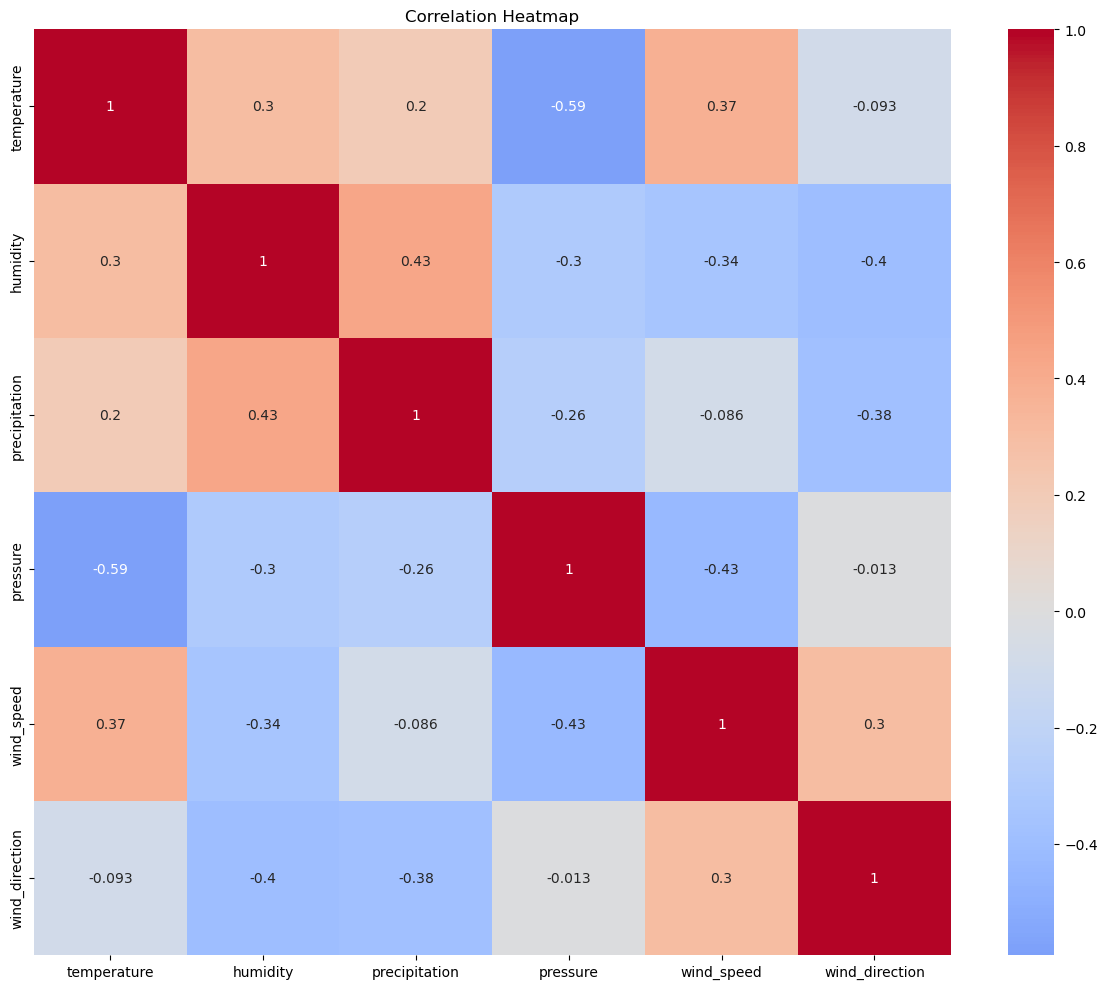

In [30]:
# Visualization of correlation
plt.figure(figsize=(12, 10))

# Heatmap of correlation
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.tight_layout()

plt.savefig('correlation_heatmap.png')
plt.show()

### The strongest correlations with temperature are:

Pressure: `-0.66` (strong negative correlation) - As temperature increases, atmospheric pressure tends to decrease significantly, which is the strongest relationship shown for temperature.

Wind speed: `0.45` (moderate positive correlation) - Higher temperatures are moderately associated with higher wind speeds.

Humidity: `0.27` (weak positive correlation) - There's a weak relationship showing slightly higher humidity with higher temperatures.

Precipitation: `0.19` (very weak positive correlation) - There's only a slight relationship between temperature and precipitation.

Wind direction: `-0.11` (very weak negative correlation) - Almost no meaningful relationship with temperature.

### Implement an unsupervised machine learning model

### Feature Selection and Engineering

#### Check for any missing values in the dataset before training

In [31]:
df.isnull().sum()

datetime              0
temperature          47
humidity             47
precipitation        47
pressure             47
wind_speed           47
wind_direction       47
weather_code         47
weather_condition    47
day                   0
hour                  0
dtype: int64

First Handle Missing Features

In [32]:
features = ['temperature', 'humidity', 'precipitation', 'pressure', 'wind_speed']

In [33]:
df_clean = df.copy()
for col in features:
    df_clean[col] = df_clean[col].fillna(df_clean[col].mean())

In [34]:
print("Missing values after handling:")
print(df_clean[features].isnull().sum())

Missing values after handling:
temperature      0
humidity         0
precipitation    0
pressure         0
wind_speed       0
dtype: int64


In [35]:
X = df_clean[features]

In [36]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Determine optimal number of clusters using Elbow Method

In [37]:
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

Plot Elbow Method

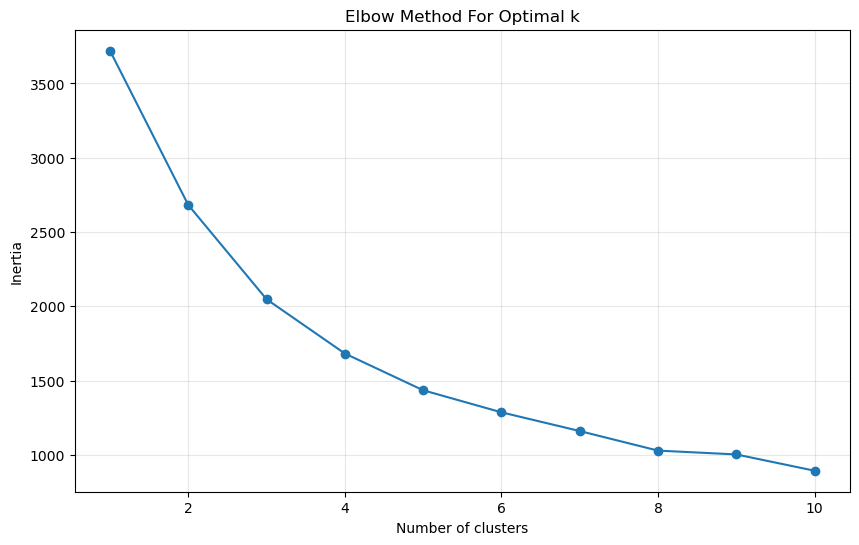

In [38]:
plt.figure(figsize=(10, 6))

# Elbow method plot
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid(True, alpha=0.3)

plt.savefig('elbow_method.png')
plt.show()

### Perform K-means clustering with optimal k

In [39]:
k_optimal = 4  # Based on the elbow curve analysis

Train Model with K-means clustering and optimal k values

In [40]:
# Initialize and train the model
kmeans = KMeans(n_clusters=k_optimal, random_state=42)

# Fit the model
df['cluster'] = kmeans.fit_predict(X_scaled)

Summary statistics of the K-means clustering or clusters

In [41]:
cluster_summary = df.groupby('cluster').agg({
    'temperature': 'mean',
    'humidity': 'mean',
    'precipitation': 'mean',
    'pressure': 'mean',
    'wind_speed': 'mean',
    'weather_condition': lambda x: x.value_counts().index[0]  # most common condition
})


cluster_summary

,temperature,humidity,precipitation,pressure,wind_speed,weather_condition
cluster,,,,,,
0,1.362722,88.372781,0.152071,1015.341420,8.322485,Overcast
1,-4.115254,57.596045,0.000565,1026.271186,8.272599,Overcast
2,1.409286,52.714286,0.003571,1009.532857,18.135000,Overcast
3,2.047059,95.970588,1.576471,1009.358824,8.991176,Dense drizzle


Visualize clusters using PCA for dimensionality reduction

In [42]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

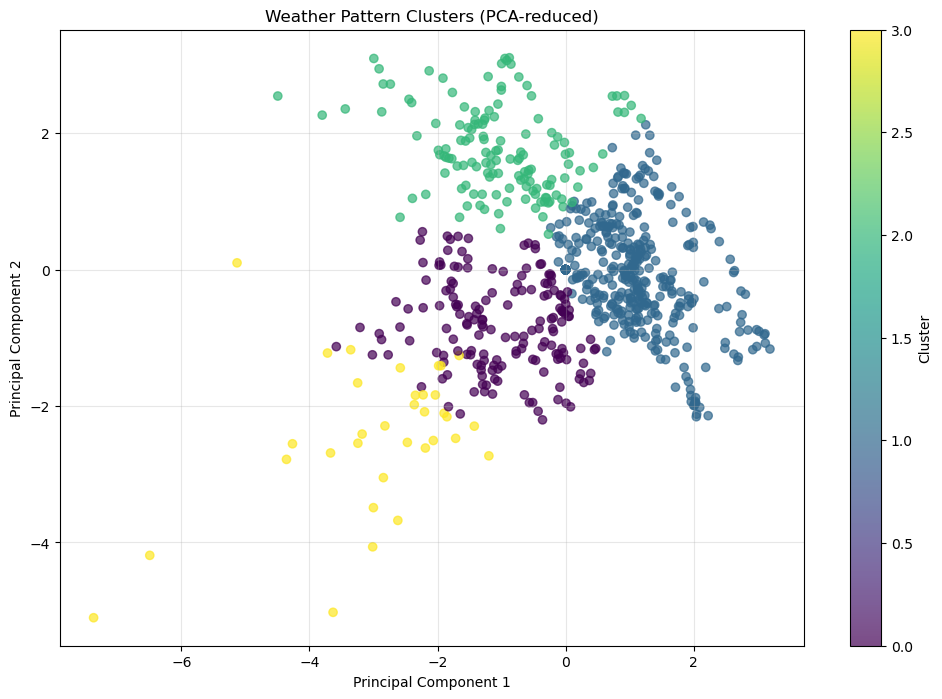

In [43]:
plt.figure(figsize=(12, 8))

scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Cluster')

plt.title('Weather Pattern Clusters (PCA-reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, alpha=0.3)

plt.savefig('weather_clusters.png')
plt.show()

### Save the trained machine learning model using joblib

In [44]:
model_filename = 'weather_model.joblib'
joblib.dump(kmeans, model_filename)

scaler_filename = 'weather_scaler.joblib'
joblib.dump(scaler, scaler_filename)

print(f"K-Means model saved as '{model_filename}'")
print(f"StandardScaler saved as '{scaler_filename}'")

K-Means model saved as 'weather_model.joblib'
StandardScaler saved as 'weather_scaler.joblib'
